In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [2]:
!git lfs pull

In [3]:
# Read the dataset
data = pd.read_csv("creditcard.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
#Removing the time column since it would not help in model training
data.drop(["Time"],axis=1,inplace = True)

In [6]:
data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
# Correlation of variables with the target class.
corr = data.corr()
corr["Class"]

V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

In [8]:
# Removing the variables which can affect the output stream
#These are features either are too negatively correlated with the target or too much positive with target(may surpress other features)
COL=["V3","V10","V12","V14","V16","V17","V18"]
data.drop(COL,axis=1,inplace=True)

In [9]:
# Lets normalise the amount column
# Need not perform scaling of other features since all values have been scaled because of the PCA applied before the data was released

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Amount'],axis=1)

In [10]:
#Checking the ratio of classes with respect to each other 
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# NO of fraud instances :: 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V4,V5,V6,V7,V8,V9,V11,V13,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
143414,1.394940,-0.725507,-0.737259,-1.243254,-0.672043,-0.872506,0.004601,-0.285987,-1.004247,-1.641884,...,-0.002746,-0.235306,0.026229,-0.176055,0.246006,-0.330504,0.006173,0.018870,0,-0.251358
14104,1.192396,1.338974,3.123672,0.643245,-1.184323,0.397586,-0.253499,0.411135,1.124059,0.367976,...,-0.377503,-0.889597,-0.074208,0.035446,0.550578,-0.027171,-0.024921,0.073605,1,-0.340755
40828,-0.085311,0.362864,-1.116120,-0.065540,-0.208380,0.436858,-0.142423,-1.954865,0.598340,0.969503,...,-0.701470,-1.655558,0.096247,-0.515665,-0.531493,0.687602,-0.145028,0.015947,0,-0.221333
102442,-13.192671,12.785971,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,4.406806,-1.909488,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1,-0.349231
238366,0.754316,2.379822,3.818392,0.043203,-1.285451,-1.766684,0.756711,-1.765722,3.592797,-0.074534,...,0.397058,0.141165,0.171985,0.394274,-0.444642,-0.263189,0.304703,-0.044362,1,-0.345233


In [12]:
np_df = np.array(new_df)

print(np_df.shape)

(984, 23)


In [13]:
# Lets split the data into features and target
features = new_df.drop(["Class"],axis =1)
target = new_df["Class"]


# Splitting the data into train and test
X_train,X_test, Y_train,Y_test = train_test_split(features, target, test_size = .3, random_state =5)

In [14]:
#Size of the input of the input layer
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dense(2, activation='softmax') #2 neurons because we have 2 output classes 
])

In [15]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 22)                506       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                736       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,308
Trainable params: 1,308
Non-trainable params: 0
_________________________________________________________________


In [16]:
#using sparse_categorial because there is a lot of sparse of values in the target so it is preferred to use this loss
# using accuracy since it is classification problem 
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
#Spliting into train, Dev set and test set
# Train = 60% Valid = 30% Test = 1% on original dataset 
X= data.drop(["Class"],axis = 1)
Y = data["Class"]

In [18]:
org_x_train_f,org_x_test,org_y_train_f,org_y_test = train_test_split(X,Y,test_size = .1,random_state = 1)
org_x_train,org_x_valid,org_y_train,org_y_valid = train_test_split(org_x_train_f,org_y_train_f,test_size = .3,random_state = 1)

In [19]:
# Using random shuffling in the dataset while fitting
history=undersample_model.fit(X_train, Y_train, batch_size=64, epochs=40, shuffle=True, verbose=2,validation_data = (org_x_valid,org_y_valid))

Train on 688 samples, validate on 76898 samples
Epoch 1/40
688/688 - 2s - loss: 1.3167 - accuracy: 0.4985 - val_loss: 1.6244 - val_accuracy: 0.1815
Epoch 2/40
688/688 - 1s - loss: 1.1273 - accuracy: 0.5828 - val_loss: 1.4049 - val_accuracy: 0.2902
Epoch 3/40
688/688 - 1s - loss: 1.0071 - accuracy: 0.6497 - val_loss: 1.2065 - val_accuracy: 0.4842
Epoch 4/40
688/688 - 1s - loss: 0.9167 - accuracy: 0.7456 - val_loss: 1.0615 - val_accuracy: 0.6806
Epoch 5/40
688/688 - 1s - loss: 0.8437 - accuracy: 0.8154 - val_loss: 0.9647 - val_accuracy: 0.7851
Epoch 6/40
688/688 - 1s - loss: 0.7810 - accuracy: 0.8590 - val_loss: 0.8797 - val_accuracy: 0.8506
Epoch 7/40
688/688 - 1s - loss: 0.7231 - accuracy: 0.8866 - val_loss: 0.8039 - val_accuracy: 0.8940
Epoch 8/40
688/688 - 1s - loss: 0.6709 - accuracy: 0.9099 - val_loss: 0.7379 - val_accuracy: 0.9171
Epoch 9/40
688/688 - 1s - loss: 0.6239 - accuracy: 0.9273 - val_loss: 0.6710 - val_accuracy: 0.9401
Epoch 10/40
688/688 - 1s - loss: 0.5826 - accuracy: 

In [20]:
#Lets check out the weights and biases in each layer
for i in range(3):
    print('Layer',i+1)
    print("-"*10)
    hidden_layer  = undersample_model.layers[i]
    weights,biases = hidden_layer.get_weights()
    print('Weights')
    print(weights)
    print("Weight shape",weights.shape)
    print("*"*10)
    print('Bias')
    print(biases)
    print("Bias shape",biases.shape)
    print("="*10)

Layer 1
----------
Weights
[[ 0.23868856  0.29309452  0.21962741 -0.04748094  0.32641578  0.21228829
  -0.10787929 -0.26484898  0.22038566 -0.31597248  0.00268067  0.24050814
   0.11692992  0.22726619  0.48657408 -0.21134874 -0.00512387  0.03728615
   0.05041993  0.07231235 -0.11355597 -0.27162257]
 [-0.42601132 -0.38456202 -0.34326285 -0.06092448  0.3592029   0.2727516
   0.250397    0.08788598 -0.1270894   0.14530356  0.23789337 -0.02748779
   0.0215415   0.10398043 -0.37066522  0.13643254  0.26213905  0.27391395
   0.28706098  0.17835414  0.02243789  0.3009376 ]
 [-0.1601958  -0.05438812  0.08635563  0.28478685 -0.14688472 -0.49139082
  -0.2629598  -0.39970896 -0.04032704  0.1012064   0.24533181 -0.07254025
   0.1768667  -0.41753834 -0.18262744  0.37410155  0.4236283   0.1241226
   0.18903199  0.01511312  0.325848    0.06574838]
 [-0.02902109  0.27585402 -0.44355428 -0.11219241 -0.1796599  -0.3077416
  -0.07647743  0.13136928 -0.15780854 -0.21720167 -0.13587677 -0.1717839
  -0.31731

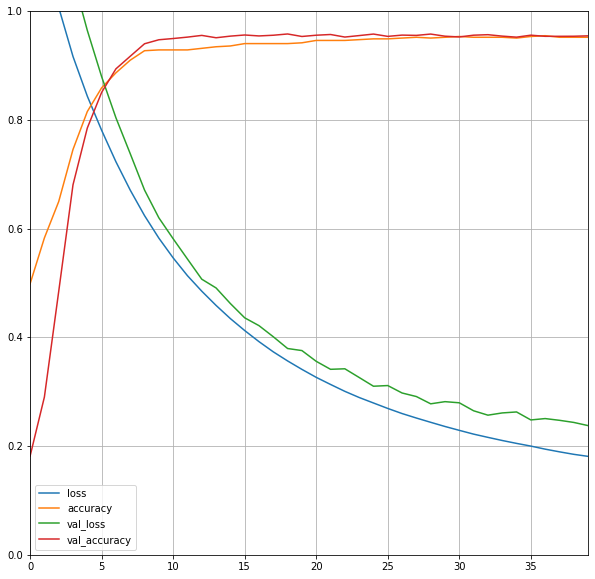

In [21]:
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [22]:
# Evaluation on test test 
acc=undersample_model.evaluate(org_x_test,org_y_test)
print('Loss : {} ,Accuracy : {}'.format(acc[0],acc[1]*100))

28481/28481 [==============================] - 1s 20us/sample - loss: 0.2427 - accuracy: 0.9523
Loss : 0.24266128307363088 ,Accuracy : 95.22839784622192


In [23]:
tf.saved_model.save(undersample_model,"saved_model/1/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/1/assets
